# Sentiment Analysis with Transformers
## By Erin Gregoire & Dawson Damuth
### June 2025

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torchmetrics import ROC
import copy
import math
import json

import torch
from torch.utils.data import TensorDataset, DataLoader
import torchinfo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using device: {device}')

using device: cuda


### Data Preprocessing

In [9]:
data = pd.read_csv('p4_data_cleaned.csv')

In [11]:
data.head()

,sentiment,vocab index
0,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,0,"[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]"
2,0,"[36, 37, 38, 39, 40, 3, 41, 42, 43, 44, 45, 46..."
3,1,"[23, 14, 53, 54, 55, 56, 57, 58, 59, 60, 61, 1..."
4,1,"[72, 73, 74, 44, 75, 76, 77, 78, 79, 80, 81, 8..."


In [11]:
data['vocab index'] = data['vocab index'].apply(json.loads)

In [12]:
lengths = data['vocab index'].apply(len)
percentile_95 = int(np.percentile(lengths, 95))
print('95th percentile will be used to pad/truncate our review lengths:', percentile_95)

95th percentile will be used to pad/truncate our review lengths: 79


In [13]:
data_padded = torch.nn.utils.rnn.pad_sequence([torch.LongTensor(seq) for seq in data['vocab index']], batch_first=True)

In [14]:
X = data_padded
y = data.iloc[:, 0]
y_tensor = torch.tensor(y.values, dtype=torch.long)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y_tensor, test_size = .1, stratify=y, random_state=676)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = len(y_val), stratify=y_train, random_state=676)

In [16]:
print('X train:', X_train.shape, '| y train:', y_train.shape)
print('X validation:', X_val.shape, '| y validation:', y_val.shape)
print('X test:', X_test.shape, '| y test:', y_test.shape)

X train: torch.Size([233600, 166]) | y train: torch.Size([233600])
X validation: torch.Size([29200, 166]) | y validation: torch.Size([29200])
X test: torch.Size([29200, 166]) | y test: torch.Size([29200])


In [19]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

## Implementation of Transformer Architecture

In [3]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_length):
        super(PositionalEncoder, self).__init__()
        pe = torch.zeros(max_length, d_model)
        pos = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)

        self.register_buffer('pe', pe.unsqueeze(0)) # batch dim

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [7]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(341963, 256)
        self.pos_encoding = PositionalEncoder(256, 166)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=4, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(256, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.pos_encoding(self.embedding(x))
        x = self.encoder(x)
        x = x.mean(dim=1)
        x = self.activation(self.fc(x))
        return x

In [51]:
net = Transformer().to(device)
torchinfo.summary(net)

Layer (type:depth-idx)                                            Param #
Transformer                                                       --
├─Embedding: 1-1                                                  87,542,528
├─PositionalEncoder: 1-2                                          --
├─TransformerEncoderLayer: 1-3                                    --
│    └─MultiheadAttention: 2-1                                    197,376
│    │    └─NonDynamicallyQuantizableLinear: 3-1                  65,792
│    └─Linear: 2-2                                                526,336
│    └─Dropout: 2-3                                               --
│    └─Linear: 2-4                                                524,544
│    └─LayerNorm: 2-5                                             512
│    └─LayerNorm: 2-6                                             512
│    └─Dropout: 2-7                                               --
│    └─Dropout: 2-8                                               --


Since our task is classification, the transformer architecture that we will use has only the encoder layers. Each encoder layer features multihead attention, fully connected network layers, layer normalization, and dropout for regularization. There are five of these encoder layers. Before the data is passed through the encoder layers, it is embedded and then positional encoding is applied. The final layer is a fully connected layer with Sigmoid activation since we have a binary classificaiton task with outputs of 0 or 1.

## Training & Hyperparameter Tuning

In [33]:
net = Transformer().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=.001)

In [35]:
epochs = 10
epoch_number = 0

start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        outputs = outputs.squeeze(1)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            voutputs = voutputs.squeeze(1)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Epoch # 1
Loss: training = 0.505287139269504, validation = 0.41522803721220597
Accuracy: training = 73.92508561643835%, validation = 80.84246575342465%
Epoch # 2
Loss: training = 0.3878535302549699, validation = 0.39541500858638595
Accuracy: training = 82.58390410958904%, validation = 82.66438356164385%
Epoch # 3
Loss: training = 0.3453538538265855, validation = 0.38533263854358507
Accuracy: training = 85.0560787671233%, validation = 83.17808219178082%
Epoch # 4
Loss: training = 0.31005071188442546, validation = 0.3879072585831518
Accuracy: training = 86.92808219178082%, validation = 83.57876712328766%
Epoch # 5
Loss: training = 0.2798608025741995, validation = 0.4114760761675627
Accuracy: training = 88.44563356164383%, validation = 83.30821917808218%
Epoch # 6
Loss: training = 0.2474902848848769, validation = 0.41732118492541104
Accuracy: training = 90.01027397260273%, validation = 82.91780821917808%
Epoch # 7
Loss: training = 0.22165438782542063, validation = 0.46381848895031474
Accu

In [37]:
# optimization 1
net = Transformer().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=.005)

In [39]:
epochs = 10
epoch_number = 0

print('Optimization Technique #1: Regularization with weight decay = .005')
start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        outputs = outputs.squeeze(1)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            voutputs = voutputs.squeeze(1)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Optimization Technique #1: Regularization with weight decay = .005
Epoch # 1
Loss: training = 0.6971739519465009, validation = 0.6914977477944415
Accuracy: training = 51.646832191780824%, validation = 53.85616438356165%
Epoch # 2
Loss: training = 0.6922038168792265, validation = 0.6925800090250762
Accuracy: training = 52.13527397260273%, validation = 50.400684931506845%
Epoch # 3
Loss: training = 0.6920354003321302, validation = 0.6918956404146941
Accuracy: training = 52.147260273972606%, validation = 50.928082191780824%
Epoch # 4
Loss: training = 0.6916205409714322, validation = 0.6899343361025271
Accuracy: training = 52.616010273972606%, validation = 53.85958904109589%
Epoch # 5
Loss: training = 0.6909367642554108, validation = 0.6877781033515931
Accuracy: training = 52.965753424657535%, validation = 56.76027397260274%
Epoch # 6
Loss: training = 0.6927203319289468, validation = 0.693689152987107
Accuracy: training = 50.93664383561644%, validation = 49.9486301369863%
Epoch # 7
Loss: t

In [40]:
# optimization 2
net = Transformer().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=.1)

In [41]:
epochs = 10
epoch_number = 0

print('Optimization Technique #2: Learning Rate Scheduler')
start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        outputs = outputs.squeeze(1)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            voutputs = voutputs.squeeze(1)
            vloss = loss_fn(voutputs, vlabels)
            scheduler.step(vloss)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Optimization Technique #2: Learning Rate Scheduler
Epoch # 1
Loss: training = 0.7022491226713341, validation = 0.6931333837301835
Accuracy: training = 50.20933219178082%, validation = 50.0582191780822%
Epoch # 2
Loss: training = 0.6930949924287242, validation = 0.6931333785471709
Accuracy: training = 51.134845890410965%, validation = 50.0582191780822%
Epoch # 3
Loss: training = 0.6930977698876589, validation = 0.6931333811386772
Accuracy: training = 51.130136986301366%, validation = 50.0582191780822%
Epoch # 4
Loss: training = 0.6930928153250069, validation = 0.6931333749190621
Accuracy: training = 51.12842465753425%, validation = 50.0582191780822%
Epoch # 5
Loss: training = 0.6930934164636368, validation = 0.693133370772652
Accuracy: training = 51.16609589041096%, validation = 50.0582191780822%
Epoch # 6
Loss: training = 0.6930954445883843, validation = 0.693133360924928
Accuracy: training = 51.172089041095894%, validation = 50.0582191780822%
Epoch # 7
Loss: training = 0.6930981818974

In [42]:
# optimization 3
net = Transformer().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(net.parameters())

In [43]:
epochs = 10
epoch_number = 0

print('Optimization Technique #3: AdamW Optimizer with adaptive weight decay & learning rate')
start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        outputs = outputs.squeeze(1)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            voutputs = voutputs.squeeze(1)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Optimization Technique #3: AdamW Optimizer with adaptive weight decay & learning rate
Epoch # 1
Loss: training = 0.48667496315490244, validation = 0.40228971009669096
Accuracy: training = 75.71232876712328%, validation = 81.82876712328768%
Epoch # 2
Loss: training = 0.3733256929610149, validation = 0.3824727009172025
Accuracy: training = 83.48073630136986%, validation = 83.26712328767123%
Epoch # 3
Loss: training = 0.33218704949072914, validation = 0.3873520884824836
Accuracy: training = 85.72303082191782%, validation = 83.4486301369863%
Epoch # 4
Loss: training = 0.3010513014430415, validation = 0.39076035385546476
Accuracy: training = 87.48073630136986%, validation = 83.40068493150685%
Epoch # 5
Loss: training = 0.2705382211837685, validation = 0.424230936040049
Accuracy: training = 88.8505993150685%, validation = 83.24657534246576%
Epoch # 6
Loss: training = 0.24122212172729685, validation = 0.4369122352289117
Accuracy: training = 90.27953767123287%, validation = 82.92808219178082%


#### Saving the best model

In [64]:
net = Transformer().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(net.parameters())

In [56]:
epochs = 5
epoch_number = 0
best_vloss = 1000000

best_train_loss = []
best_val_loss = []
best_train_accuracy = []
best_val_accuracy = []

print('Best Model: AdamW Optimizer with adaptive weight decay & learning rate')
start_time = time.time()
for epoch in range(epochs):
    print(f'Epoch # {epoch_number+1}')

    net.train(True)
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        outputs = outputs.squeeze(1)
    
        loss = loss_fn(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights
        running_loss += loss.item()
        
        preds = (outputs >= .5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = (correct / total) * 100
    avg_loss = running_loss / len(train_loader)
    best_train_loss.append(avg_loss)
    best_train_accuracy.append(train_acc)

    running_vloss = 0.0
    net.eval() # set to evaluation mode
    vcorrect = 0
    vtotal = 0

    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.float().to(device)
            voutputs = net(vinputs)
            voutputs = voutputs.squeeze(1)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

            vpreds = (voutputs >= .5).float()
            vcorrect += (vpreds == vlabels).sum().item()
            vtotal += vlabels.size(0)

    val_acc = (vcorrect / vtotal) * 100
    avg_vloss = running_vloss / len(val_loader)
    best_val_loss.append(avg_vloss)
    best_val_accuracy.append(val_acc)
    
    print('Loss: training = {}, validation = {}'.format(avg_loss, avg_vloss))
    print('Accuracy: training = {}%, validation = {}%'.format(train_acc, val_acc))

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_model = copy.deepcopy(net.state_dict())
        torch.save(best_model, 'a2_part_4_dawsonda_ergregoi.pth')

    epoch_number += 1

end_time = time.time()
estimated_training_time = end_time - start_time
print(f'Estimated training time: {round(estimated_training_time/60, 2)} minutes')

Best Model: AdamW Optimizer with adaptive weight decay & learning rate
Epoch # 1
Loss: training = 0.49801144813394493, validation = 0.41413625997045767
Accuracy: training = 74.7722602739726%, validation = 81.16780821917808%
Epoch # 2
Loss: training = 0.3802708210454191, validation = 0.3797838698262754
Accuracy: training = 83.07020547945206%, validation = 83.06164383561644%
Epoch # 3
Loss: training = 0.3362752154779591, validation = 0.3869849101356838
Accuracy: training = 85.52482876712328%, validation = 82.7123287671233%
Epoch # 4
Loss: training = 0.3025956087442766, validation = 0.3968831401804219
Accuracy: training = 87.32662671232877%, validation = 83.45890410958904%
Epoch # 5
Loss: training = 0.270392854856113, validation = 0.3939448105252307
Accuracy: training = 88.94820205479452%, validation = 83.23630136986301%
Estimated training time: 22.53 minutes


In [66]:
epochs = 1
predictions = []
targets = []
roc_outputs = []

for epoch in range(epochs):
    best_nn_path = torch.load('a2_part_4_dawsonda_ergregoi.pth', weights_only=True)
    net.load_state_dict(best_nn_path)

    running_loss = 0.0
    net.eval() # set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            outputs = net(inputs)
            outputs = outputs.squeeze(1)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            
            preds = (outputs >= .5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            predictions.append(preds)
            targets.append(labels)
            roc_outputs.append(outputs)

    test_acc = (correct / total) * 100
    avg_test_loss = running_loss / len(test_loader)

print(f'Test Loss: {avg_test_loss}')
print(f'Test Accuracy: {test_acc}%')

Test Loss: 0.38151270462119063
Test Accuracy: 82.92808219178082%


The first optimization technique that I used was adding regularization by adding weight decay to the Adam optimizer. Unfortunately, this completely decreased the performance of the transformer and made the validation accuracy rather instable. After this, I tried using a learning rate scheduler which also decresed the model's performance and let to very little change in the model's performance as epochs progressed. The last optimization technique that I used was changing the optimizer to Adam W. This is because the Adam W optimizer adaptively updates the learning rate and weight decay dynamically as the epochs progress. Since I had such little luck manually adjusting my learning rate and regularization, I believe that this was the smart next choice to combine the two while doing so adaptively. In the end, AdamW did not perform signficantly differently than the Adam optimizer that had no weight decay and a fixed learning rate. However, I believe that AdamW is still preferable due to its ability to be adaptive and dynamic with learning rate and regularization. I did not utilize dropout as an additional optimization technique because my transformer's encoder layers already have dropout built in to help prevent overfitting and increase generalization. After closely monitoring during training and optimization runs, I will run the final best model for only 5 epochs as a way of early stopping of sorts to help prevent overfitting.

In [68]:
print(f'Best Model Loss: Training = {best_train_loss[-1]}, Validation = {best_val_loss[-1]}, Test = {avg_test_loss}')
print(f'Best Model Accuracy: Training = {best_train_accuracy[-1]}%, Validation = {best_val_accuracy[-1]}%, Test = {test_acc}%')

Best Model Loss: Training = 0.270392854856113, Validation = 0.3939448105252307, Test = 0.38151270462119063
Best Model Accuracy: Training = 88.94820205479452%, Validation = 83.23630136986301%, Test = 82.92808219178082%


The best model ended training with a high training accuracy and low loss values. The validation and test sets also passed the expected threshold of 80% which was the model's goal. Some overfitting can be seen by the higher values on the training dataset, but not significantly so as it is in a healthy range. 

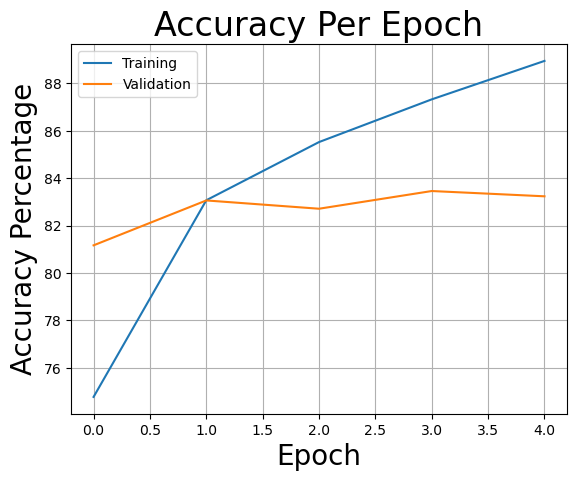

In [70]:
plt.figure()
plt.plot(best_train_accuracy, label = 'Training')
plt.plot(best_val_accuracy, label = 'Validation')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Accuracy Percentage', fontsize=20)
plt.title('Accuracy Per Epoch', fontsize=24)
plt.legend() 
plt.grid()
plt.show()

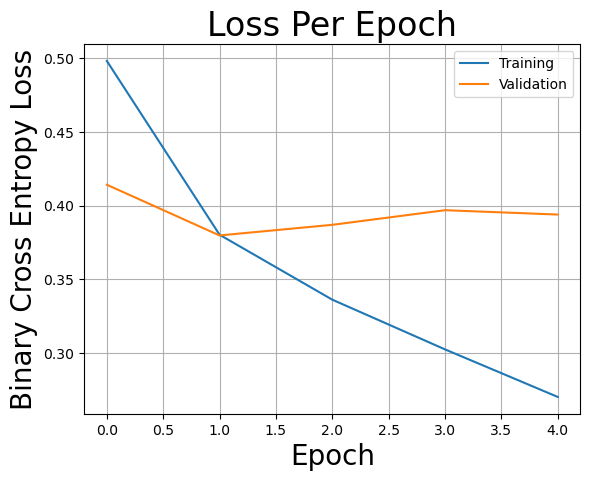

In [72]:
plt.figure()
plt.plot(best_train_loss, label = 'Training')
plt.plot(best_val_loss, label = 'Validation')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Binary Cross Entropy Loss', fontsize=20)
plt.title('Loss Per Epoch', fontsize=24)
plt.legend() 
plt.grid()
plt.show()

In [74]:
preds2 = torch.cat(predictions)
preds2 = preds2.to('cpu')
targets2 = torch.cat(targets)
targets2 = targets2.to('cpu')

In [76]:
scores = precision_recall_fscore_support(targets2, preds2, average='macro')
print(f'Precision: {scores[0]}, Recall: {scores[1]}, F1 Score: {scores[2]}')

Precision: 0.829291884980119, Recall: 0.8292837731696798, F1 Score: 0.8292801249344564


A common goal for precision, recall, and f1 scores are to be above .80. Fortunately, all three of these scores are above .80 on the test set meaning that the model was able to accurately learn the best weights, correctly identify the sentiments and attain a high output quality.

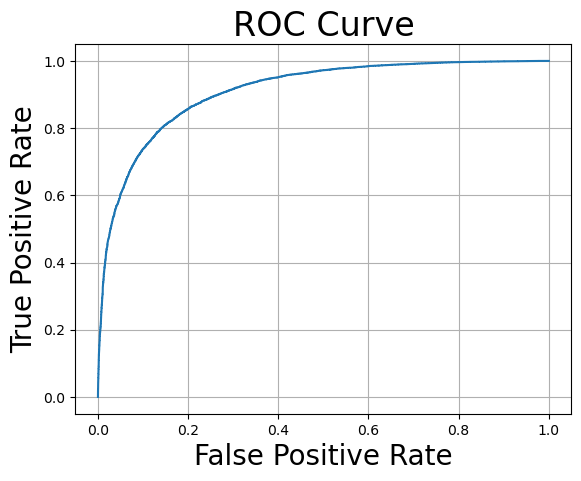

In [92]:
roc_outputs2 = torch.cat(roc_outputs)
roc_outputs2 = roc_outputs2.to('cpu')
targets3 = targets2.long()
roc = ROC(task="binary")
fpr, tpr, thresholds = roc(roc_outputs2, targets3)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve', fontsize=24)
plt.grid()
plt.show()

When looking at a ROC curve, the goal is to have the curve hug the lefthand corner as tightly as possible. Seeing as there is a great curve here and it is tight to the upper left corner, this shows that the model does a good job at accurately predicting true positives and avoiding false positives.

##### References

Dataset: "amazon_review_full_csv.tar.gz"

PyTorch Contributors. "TransformerDecoder." PyTorch, https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html. Accessed 26 June 2025.

PyTorch Contributors. "TransformerEncoder." PyTorch, https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html. Accessed 26 June 2025.

Reher, Dorothea. "How to Build and Train a PyTorch Transformer Encoder." BuiltIn, 2 Apr 2025, https://builtin.com/artificial-intelligence/pytorch-transformer-encoder. Accessed 25 June 2025. 

Sarkar, Arjun. "Build your own Transformer from scratch using Pytorch." Medium, 26 Apr 2023, https://medium.com/data-science/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb. Accessed 25 June 2025. 